<a href="https://colab.research.google.com/github/Pierre-Chisenga/Cadio-Vascular-prediction/blob/main/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model Project based on MNIST

The task at hand involves building an end-to-end machine learning pipeline to classify handwritten digits from the MNIST dataset using advanced machine learning techniques, specifically Convolutional Neural Networks (CNNs). The underlying business problem is to accurately and efficiently classify handwritten digits, which is crucial in applications such as automated form processing, digit recognition in postal services, and banking systems. Accurate digit classification can significantly reduce manual data entry errors, increase processing speed, and improve overall operational efficiency.

**Loading the dataset**

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/mnist.csv")
data.head()

,id,class,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,31953,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34452,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60897,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,36953,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1981,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.shape

(4000, 786)

**Checking for missing values**

In [ ]:
result = data.isnull().sum()
print(result)

id          0
class       0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 786, dtype: int64


**Seperating the features and target**

In [ ]:
x = data.drop(['id', 'class'], axis=1).values
y = data['class'].values

**Normalization of the pixels**

The pixel values range from 0 to 255, representing the intensity of each pixel.

In [ ]:
x = x/255.0

**Reshaping the data to 28x28 images with a channel**

In [ ]:
x.shape

(4000, 784)

In [ ]:
x = x.reshape(-1, 28, 28, 1)

In [ ]:
x.shape

(4000, 28, 28, 1)

**Converting lables to categorical format**

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=10)

**Dimention reduction**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
#flattening the data to 2D
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(x.shape[0], -1))

# Appling the PCA
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

In [ ]:
explained_variance = pca.explained_variance_ratio_

# Calculating the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

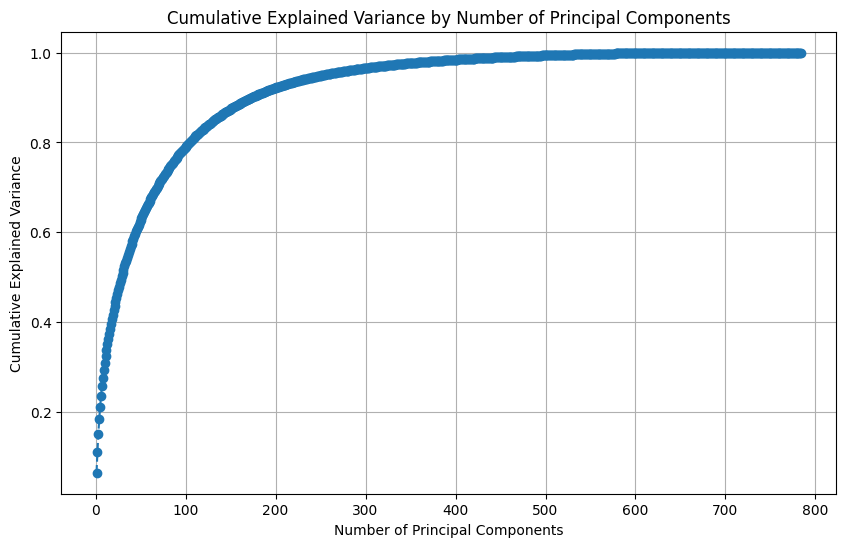

In [ ]:
# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()


In [ ]:
# Determining the number of components that explain at least 95% of the variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Number of components that explain at least 95% of the variance: {num_components}')

Number of components that explain at least 95% of the variance: 253


In [ ]:
pca = PCA(n_components=253)
x_pca = pca.fit_transform(x_scaled)

**Split the dataset into train,test and validation**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((3200, 28, 28, 1), (3200, 10)),
 ((400, 28, 28, 1), (400, 10)),
 ((400, 28, 28, 1), (400, 10)))

**Building the model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CNN model
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(10, activation='softmax'))  # Output layer with 10 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])



Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.3398 - accuracy: 0.5650

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 5s 83ms/step - loss: 1.3398 - accuracy: 0.5650 - val_loss: 0.4651 - val_accuracy: 0.8700
Epoch 2/50
50/50 [==============================] - 3s 61ms/step - loss: 0.4622 - accuracy: 0.8581 - val_loss: 0.2289 - val_accuracy: 0.9375
Epoch 3/50
50/50 [==============================] - 3s 53ms/step - loss: 0.2818 - accuracy: 0.9116 - val_loss: 0.1734 - val_accuracy: 0.9425
Epoch 4/50
50/50 [==============================] - 2s 49ms/step - loss: 0.1965 - accuracy: 0.9359 - val_loss: 0.1367 - val_accuracy: 0.9550
Epoch 5/50
50/50 [==============================] - 2s 49ms/step - loss: 0.1636 - accuracy: 0.9522 - val_loss: 0.1043 - val_accuracy: 0.9650
Epoch 6/50
50/50 [==============================] - 4s 72ms/step - loss: 0.1284 - accuracy: 0.9578 - val_loss: 0.0801 - val_accuracy: 0.9700
Epoch 7/50
50/50 [==============================] - 3s 62ms/step - loss: 0.1060 - accuracy: 0.9663 - val_loss: 0.0733 - val_accuracy: 0.9700
Epoch 8/50
50/50 [======

In [ ]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

13/13 [==============================] - 0s 8ms/step - loss: 0.1069 - accuracy: 0.9625
Test accuracy: 0.9625


The model is evaluated on the test set to determine its accuracy, which was found to be 96.25%.

Text(0.5, 1.0, 'Training and Validation Accuracy')

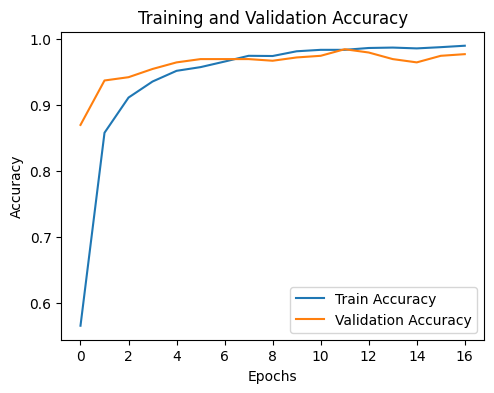

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

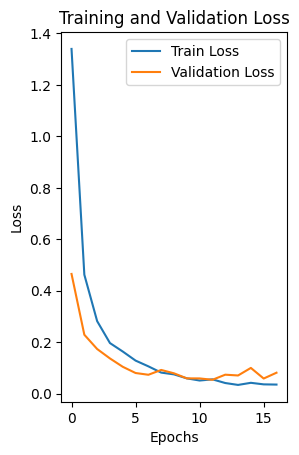

In [ ]:
# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

**Strengths and Limitations:**

**Strengths:** Our model performed exceptionally well on the test data, showcasing its ability to accurately classify handwritten digits. The use of Convolutional Neural Networks (CNNs) is particularly advantageous because they automatically extract important features from the images, eliminating the need for manual feature engineering.

**Limitations:** Despite its high accuracy, the model may struggle with digits that are written in significantly different styles or are poorly formed. This can impact its generalizability to a broader range of handwriting.

Automating the process of digit classification can greatly enhance the efficiency and accuracy of data entry in various industries. This can lead to significant cost savings and a reduction in human error, which is crucial for operations such as automated form processing and digit recognition in postal services and banking.

**Recommendations:**

To further improve the model's performance:

Hyperparameter Tuning: Experimenting with different hyperparameters and CNN architectures could lead to better results.
Data Augmentation: Applying data augmentation techniques can increase the diversity of the training data, making the model more robust and able to handle a wider variety of handwriting styles.

**Conclusion**

This project successfully demonstrates the effectiveness of CNNs in classifying handwritten digits. By systematically preprocessing the data, training the model, and evaluating its performance, we developed a reliable solution with substantial potential for various business applications. This structured approach underscores the power and versatility of CNNs in image classification tasks.

**References**

Dataset URL: [kaggles.dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Documentation: TensorFlow and Keras Documentation